In [2]:
import numpy as np
import pandas as pd
import os
import json
from captum.attr import IntegratedGradients,Occlusion
from nilearn.image import load_img,resample_img 

import torch
from torch import nn 
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from custom_dataset import CustomDataset
from network import Network
from utils import *
import torch.nn.functional as F

In [3]:
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedShuffleSplit
from matplotlib import pyplot as plt

In [4]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=26)

torch.manual_seed(52)
np.random.seed(52)
# number of subprocesses to use for data loading
num_workers = 1
# how many samples per batch to load
batch_size = 1

data = CustomDataset(train= True,valid=False)

train_idx, valid_idx = next(sss.split(np.zeros_like(data.vars),
    data.vars.new_score.values))

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(data,batch_size=batch_size, 
                            sampler= train_sampler, num_workers=num_workers)
valid_loader = DataLoader(data,batch_size=batch_size, 
                            sampler= valid_sampler, num_workers=num_workers)

In [5]:
X_all = []
y_all = []
for X,y,_ in train_loader:
    X = X.numpy()
    X = X.reshape((X.shape[0],-1))
    X_all.append(X)
    y_all.append(y.item())
    

In [6]:
X = np.stack(X_all,axis=0)

In [7]:
X = X.squeeze()

In [8]:
X.shape

(4423, 2122945)

In [9]:
mean_img = np.mean(X,axis=0)

In [10]:
mean_img = mean_img.reshape((-1))

In [11]:
mean_img.shape

(2122945,)

In [12]:
X_filtered = X[:,mean_img > 0.2]

In [13]:
X_filtered.shape

(4423, 472035)

In [14]:
transformer = PCA(n_components=0.8,svd_solver='full')

In [15]:
transformer.fit(X_filtered)

PCA(n_components=0.8, svd_solver='full')

In [16]:
transformer.explained_variance_ratio_

array([0.08756388, 0.07423471, 0.03181009, 0.02291649, 0.01879165,
       0.01685498, 0.01230594, 0.01047203, 0.00952264, 0.00867384,
       0.007925  , 0.00746455, 0.00674735, 0.00642179, 0.00614457,
       0.00600922, 0.00557552, 0.00522051, 0.00513167, 0.0049567 ,
       0.00467507, 0.00424356, 0.00416925, 0.00412286, 0.00402927,
       0.00392522, 0.00376958, 0.00371709, 0.00363839, 0.00353453,
       0.00346891, 0.00329736, 0.00326505, 0.00317512, 0.00312213,
       0.00301959, 0.00293078, 0.00276371, 0.00274893, 0.00265883,
       0.00263223, 0.0026063 , 0.00255841, 0.00251184, 0.00244838,
       0.002397  , 0.00236   , 0.0022985 , 0.00222546, 0.00218826,
       0.0021359 , 0.00206965, 0.00204199, 0.00199743, 0.00198658,
       0.00195325, 0.00190124, 0.00188489, 0.00184289, 0.00182304,
       0.00178275, 0.00175911, 0.00172808, 0.00168618, 0.0016461 ,
       0.00164022, 0.00161348, 0.00160244, 0.00157365, 0.00152726,
       0.00152017, 0.00151656, 0.00148623, 0.00146348, 0.00144

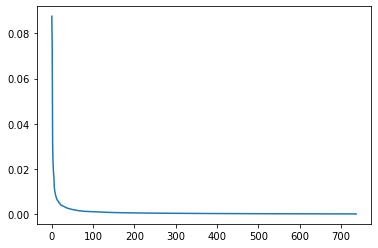

In [19]:
plt.plot(transformer.explained_variance_ratio_,'-')

In [20]:
transformer.n_components_

738

In [21]:
X_transformed = transformer.transform(X_filtered)

In [22]:
X_transformed.shape

(4423, 738)

In [23]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [24]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_transformed, y_all)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [25]:
from sklearn.metrics import balanced_accuracy_score

In [26]:
X_valid = []
y_valid = []
for X,y,_ in valid_loader:
    X = X.numpy()
    X = X.reshape((X.shape[0],-1))
    X_valid.append(X)
    y_valid.append(y.item())

In [27]:
X_valid = np.stack(X_valid,axis=0)

In [28]:
X_valid = X_valid.squeeze()

In [29]:
X_valid.shape

(492, 2122945)

In [30]:
X_valid = X_valid[:,mean_img > 0.2]

In [31]:
X_valid.shape

(492, 472035)

In [32]:
X_valid_transformed = transformer.transform(X_valid)

In [33]:
X_valid_transformed.shape

(492, 738)

In [34]:
clf.score(X_valid_transformed,y_valid)

0.6463414634146342

### Control overfitting

#### Select less number of components

In [35]:
transformer.components_.shape

(738, 472035)

In [36]:
X_filtered.shape

(4423, 472035)

In [37]:
X_valid.shape

(492, 472035)

In [38]:
def compute_accuracy(clf,X,y,X_valid,y_valid,num_comp):
    X = np.matmul(X,transformer.components_[:num_comp,:].T)
    X_valid = np.matmul(X_valid,transformer.components_[:num_comp,:].T)
    clf.fit(X,y)
    y_pred_train = clf.predict(X)
    y_pred_valid = clf.predict(X_valid)
    return (clf.score(X,y),balanced_accuracy_score(y,y_pred_train),
            clf.score(X_valid,y_valid),balanced_accuracy_score(y_valid,y_pred_valid))

In [39]:
accuracies = [compute_accuracy(clf,X_filtered,y_all,X_valid,y_valid,i) for i in [50,75,100,150,200,250,300,350,400,450,500,550]] 

In [40]:
pd.DataFrame(accuracies,columns=['acc_train','bal_train','acc_valid','bal_valid'],index= [50,75,100,150,200,250,300,350,400,450,500,550])

,acc_train,bal_train,acc_valid,bal_valid
50,0.784535,0.717048,0.650407,0.563627
75,0.831788,0.780352,0.658537,0.582351
100,0.858241,0.814487,0.648374,0.578128
150,0.885598,0.847403,0.664634,0.593301
200,0.899616,0.865639,0.686992,0.621899
250,0.905494,0.873255,0.684959,0.622787
300,0.911825,0.880949,0.672764,0.612026
350,0.916120,0.885954,0.674797,0.621038
400,0.919059,0.889762,0.670732,0.616626
450,0.926747,0.900303,0.674797,0.627226


In [41]:
!pip install lazypredict

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 15.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 55.0 MB/s eta 0:00:00:00:01


In [43]:
from lazypredict.Supervised import LazyClassifier

In [44]:
clf = LazyClassifier(predictions=True)

In [47]:
models = []
for i in [50,75,100,150,200,250,300,350,400,450,500,550]:
    X_fil = np.matmul(X_filtered,transformer.components_[:i,:].T)
    X_val = np.matmul(X_valid,transformer.components_[:i,:].T)
    model, prediction = clf.fit(X_fil, X_val, y_all, y_valid)
    models.append(model)

'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 29/29 [00:19<00:00,  1.50it/s]


'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 29/29 [00:25<00:00,  1.15it/s]


'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 29/29 [00:31<00:00,  1.09s/it]


'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 29/29 [00:44<00:00,  1.54s/it]


'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 29/29 [00:55<00:00,  1.91s/it]


'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 29/29 [01:10<00:00,  2.42s/it]


'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 29/29 [01:23<00:00,  2.86s/it]


'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 29/29 [01:36<00:00,  3.33s/it]


'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 29/29 [01:49<00:00,  3.79s/it]


'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 29/29 [02:00<00:00,  4.15s/it]


'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 29/29 [02:10<00:00,  4.50s/it]


'tuple' object has no attribute '__name__'
Invalid Classifier(s)


100%|██████████| 29/29 [02:22<00:00,  4.92s/it]


In [1]:
models[10]

NameError: name 'models' is not defined